In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/ambulance_routing_dataset1.csv'
df = pd.read_csv(file_path)

In [7]:
print(df.columns)

Index(['Ambulance Latitude', 'Ambulance Longitude', 'Hospital Latitude',
       'Hospital Longitude', 'Traffic Level', 'Weather Type', 'Road Type',
       'Distance to Hospital', 'Traffic Speed', 'Time of Day',
       'Estimated Travel Time (Target)'],
      dtype='object')


In [25]:
df.head()

,Ambulance Latitude,Ambulance Longitude,Hospital Latitude,Hospital Longitude,Traffic Level,Weather Type,Road Type,Distance to Hospital,Traffic Speed,Time of Day,Estimated Travel Time (Target)
0,12.956638,77.626077,13.0,77.7,Moderate,Snowy,Main Road,9.349159,49.035258,Evening,11.439718
1,12.871174,77.845704,13.1,77.8,Low,Rainy,Highway,25.921695,81.070959,Morning,19.184449
2,12.904345,77.892298,12.9,77.6,Moderate,Rainy,Highway,31.685155,31.874026,Afternoon,59.644467
3,13.100339,77.989387,12.9,77.6,Low,Clear,Highway,47.708350,69.246106,Afternoon,41.338079
4,13.070092,77.769220,12.9,77.6,High,Foggy,Residential,26.341923,15.283910,Afternoon,103.410409


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


X = df.drop(columns=['Estimated Travel Time (Target)'])
y = df['Estimated Travel Time (Target)']

categorical_features = ['Traffic Level', 'Weather Type', 'Road Type', 'Time of Day']
numerical_features = X.columns.difference(categorical_features)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [6]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

# Define the BiLSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 616.4928 - mae: 12.6777 - val_loss: 15.6496 - val_mae: 2.1030
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 29.6620 - mae: 3.0651 - val_loss: 6.4605 - val_mae: 1.3704
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 20.3819 - mae: 2.4871 - val_loss: 2.0158 - val_mae: 0.7051
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 15.9144 - mae: 2.2081 - val_loss: 2.5319 - val_mae: 0.8574
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 13.8866 - mae: 2.0459 - val_loss: 2.2691 - val_mae: 0.9842
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 12.1155 - mae: 1.9643 - val_loss: 2.6460 - val_mae: 0.8740
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 12.1600 - mae: 1.9537 - val_loss: 2.2548 - val_mae: 0.8447
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 10.3420 - mae: 1.8544 - val_loss: 3.3281 - val_mae: 0.9181
Epoch 9/50
2000/2000 

In [9]:

from sklearn.metrics import mean_absolute_percentage_error, r2_score
import numpy as np


y_pred = model.predict(X_test)


y_pred = y_pred.flatten()


y_test = np.array(y_test).flatten()


mae = np.mean(np.abs(y_test - y_pred))
print(f'MAE: {mae}')


mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape * 100:.2f}%')


r2 = r2_score(y_test, y_pred)
print(f'R²: {r2:.4f}')


naive_forecast_errors = np.abs(y_test[1:] - y_test[:-1])
mase = np.mean(np.abs(y_test[1:] - y_pred[1:])) / np.mean(naive_forecast_errors)
print(f'MASE: {mase:.4f}')


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 2.968564248242163
MAPE: 25.14%
R²: 0.9897
MASE: 0.0867


In [10]:

import keras
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Attention, Concatenate, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Define the BiLSTM model with Attention Mechanism
def create_model_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    attention = Attention()([x, x])  # Apply built-in attention layer (self-attention)
    x = Dense(64, activation='relu')(attention)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)  # Single output for the travel time prediction
    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mape'])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])

# Create and train the model with Attention Mechanism
model_with_attention = create_model_with_attention(input_shape)
model_with_attention.summary()

# Train the model
history = model_with_attention.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_pred = model_with_attention.predict(X_test)

# Flatten y_pred and y_test
y_pred = y_pred.flatten()
y_test = np.array(y_test).flatten()

# Calculate metrics
mae = np.mean(np.abs(y_test - y_pred))
print(f'MAE: {mae}')

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape * 100:.2f}%')

r2 = r2_score(y_test, y_pred)
print(f'R²: {r2:.4f}')


naive_forecast_errors = np.abs(y_test[1:] - y_test[:-1])
mase = np.mean(np.abs(y_test[1:] - y_pred[1:])) / np.mean(naive_forecast_errors)
print(f'MASE: {mase:.4f}')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1, 16)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 1, 128)         │         41,472 │ input_layer_1[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1, 128)         │              0 │ bidirectional_2[0][0], │
│                           │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 64)          │          8,256 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 64)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1)           │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,793 (194.50 KB)

 Trainable params: 49,793 (194.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 521.6069 - mae: 12.2641 - mape: 38.5964 - val_loss: 2324.0515 - val_mae: 33.4360 - val_mape: 167.7784
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 41.3003 - mae: 3.7975 - mape: 13.6636 - val_loss: 2324.4492 - val_mae: 33.1614 - val_mape: 168.0677
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 31.0202 - mae: 3.2455 - mape: 10.7422 - val_loss: 2382.1348 - val_mae: 33.5867 - val_mape: 172.5304
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 27.5705 - mae: 2.9962 - mape: 8.9716 - val_loss: 2277.4026 - val_mae: 32.8841 - val_mape: 167.9171
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 24.7819 - mae: 2.8673 - mape: 8.4590 - val_loss: 2328.3005 - val_mae: 33.0597 - val_mape: 168.1167
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 25.0552 - mae: 2.8112 - mape: 7.9782 - val_loss: 2300.9407 - val_mae: 32.8870 - val_mape: 166.6675
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


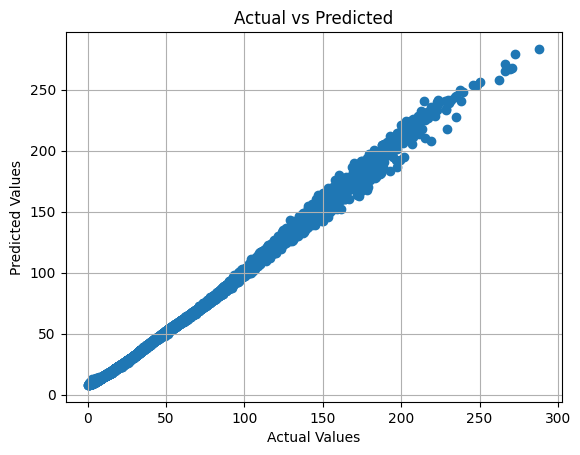

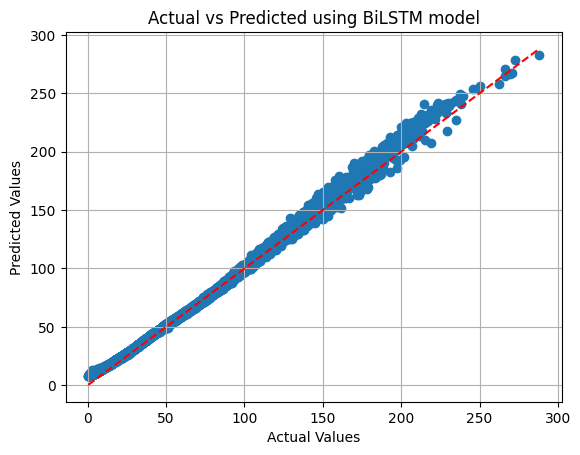

In [36]:
import numpy as np
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)


plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='r')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted using BiLSTM model')
plt.grid(True)
plt.show()


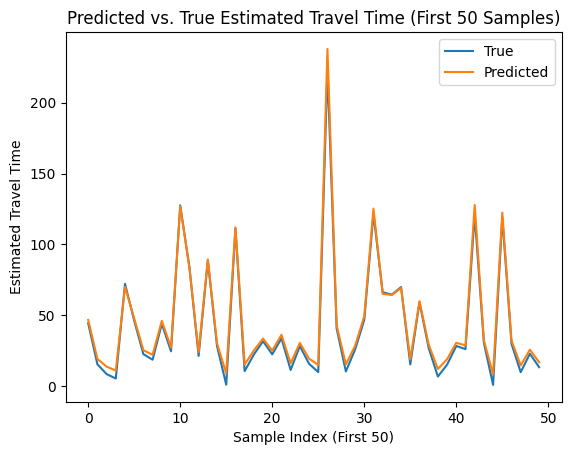

In [18]:
plt.plot(y_test[:50], label="True")
plt.plot(y_pred[:50], label="Predicted")
plt.xlabel("Sample Index (First 50)")
plt.ylabel("Estimated Travel Time")
plt.title("Predicted vs. True Estimated Travel Time (First 50 Samples)")
plt.legend()
plt.show()


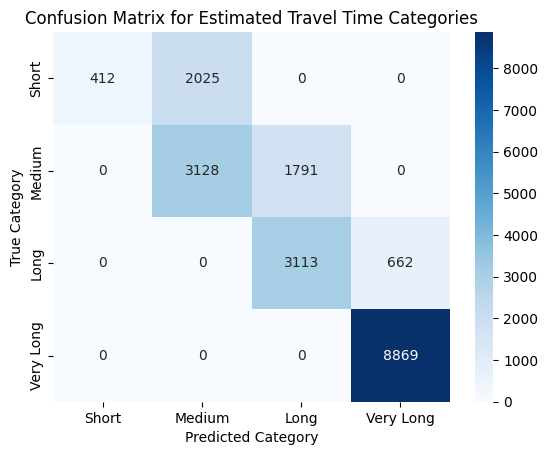

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


bins = [0, 10, 20, 30, np.inf]
y_true_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred, bins) - 1


cm = confusion_matrix(y_true_binned, y_pred_binned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Short", "Medium", "Long", "Very Long"],
            yticklabels=["Short", "Medium", "Long", "Very Long"])
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Confusion Matrix for Estimated Travel Time Categories")
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score, median_absolute_error, max_error


mape = mean_absolute_percentage_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_e = max_error(y_test, y_pred)


metrics_dict = {
    "Metric": ["MAE", "MSE", "RMSE", "R2 Score", "MAPE", "Explained Variance", "Median Absolute Error", "Max Error", "Adjusted R2"],
    "Value": [mae, mse, rmse, r2, mape, evs, medae, max_e, r2 - (1 - r2) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)]
}


metrics_df = pd.DataFrame(metrics_dict)


print(metrics_df)


                  Metric      Value
0                    MAE   2.968564
1                    MSE  12.523629
2                   RMSE   3.538874
3               R2 Score   0.989727
4                   MAPE   0.251384
5     Explained Variance   0.995886
6  Median Absolute Error   2.628606
7              Max Error  25.922527
8            Adjusted R2   0.979454


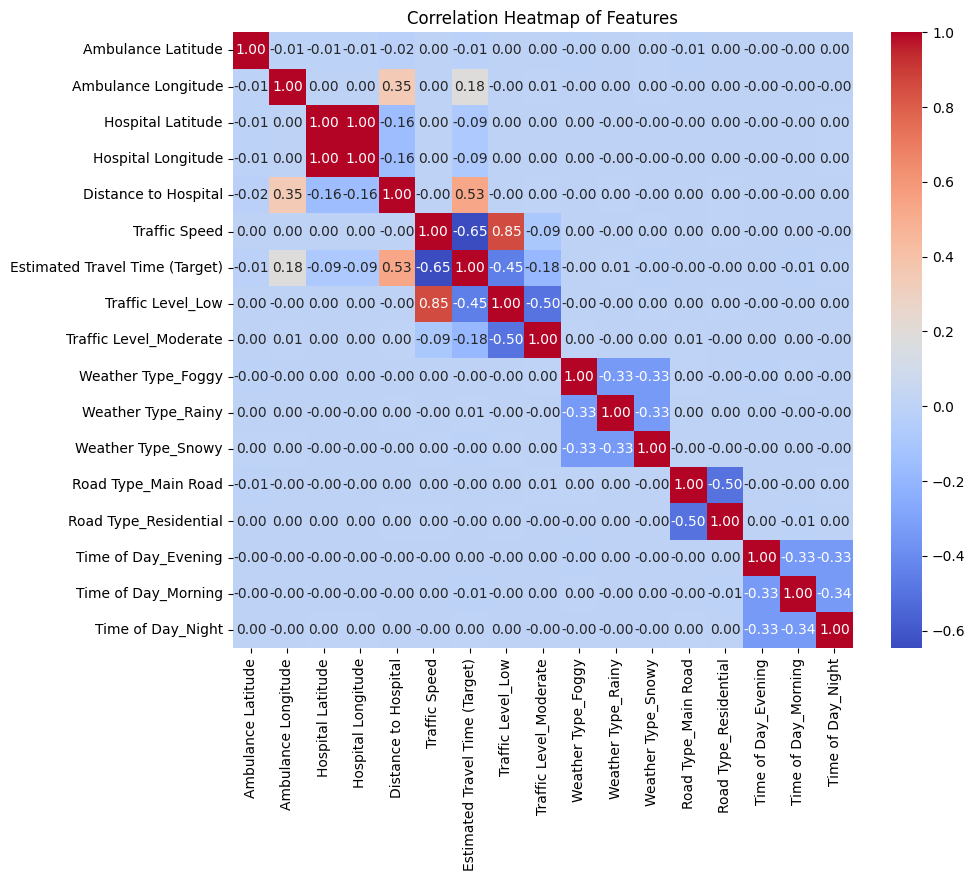

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


categorical_columns = ['Traffic Level', 'Weather Type', 'Road Type', 'Time of Day']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


correlation_matrix = df_encoded.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()
